# JAX

JAX follows the *functional programming* paradigm. That is, JAX provides tools to transform a function into another function. Specifically, JAX can automatically compute the *derivative* of a function or composition of functions.

As an example, for $f(x) = \frac{1}{2}\|x\|_2^2$, JAX computes $\nabla{f} : \mathbb{R}^n \to \mathbb{R}^n$ where $\nabla{f}(x) = x$.

In [1]:
import jax
import jax.numpy as jnp

def f(x):
    return jnp.sum(x**2)/2   # identical to numpy syntax

grad_f = jax.grad(f)         # compute the gradient function

x = jnp.array([0., 1., 2.])  # use JAX arrays!
print('x:        ', x)
print('f(x):     ', f(x))
print('grad_f(x):', grad_f(x))

x:         [0. 1. 2.]
f(x):      2.5
grad_f(x): [0. 1. 2.]


# Automatic Differentation

Consider the function $f : \mathbb{R}^n \to \mathbb{R}^m$. The Jacobian of $f$ evaluated at the point $x \in \mathbb{R}^n$ is the matrix

$$
\partial{f}(x) = \begin{bmatrix}
    \frac{\partial f_1}{\partial x_1}(x) 
    & \frac{\partial f_1}{\partial x_2}(x)
    & \cdots
    & \frac{\partial f_1}{\partial x_n}(x)
    \\
    \frac{\partial f_2}{\partial x_1}(x) 
    & \frac{\partial f_2}{\partial x_2}(x)
    & \cdots
    & \frac{\partial f_2}{\partial x_n}(x)
    \\
    \vdots & \vdots & \ddots & \vdots
    \\
    \frac{\partial f_m}{\partial x_1}(x) 
    & \frac{\partial f_m}{\partial x_2}(x)
    & \cdots
    & \frac{\partial f_m}{\partial x_n}(x)
\end{bmatrix}
= \left[\frac{\partial f_i}{\partial x_j}(x)\right]_{i=1,j=1}^{m,n} \in \mathbb{R}^{m \times n}.
$$

As for any matrix, the Jacobian $\partial{f}(x) : \mathbb{R}^n \to \mathbb{R}^m$ is a linear map $v \mapsto \partial{f}(x)v$ defined by the usual matrix-vector multiplication rules.

*Automatic Differentiation (AD, autodiff)* uses pre-defined derivatives and the chain rule to compute derivatives of more complex functions. 

In particular, AD can be used to compute the *Jacobian-Vector Product (JVP)*

$$
\begin{aligned}
    \partial{f}(x) : \mathbb{R}^n &\to \mathbb{R}^m
    \\ v &\mapsto \partial{f}(x)v
\end{aligned}
$$

and the *Vector-Jacobian Product (VJP)*

$$
\begin{aligned}
    \partial{f}(x)^\top : \mathbb{R}^m &\to \mathbb{R}^n
    \\ w &\mapsto \partial{f}(x)^\top w
\end{aligned}
$$

The maps $v \mapsto \partial{f}(x)v$ and $w \mapsto \partial{f}(x)^\top w$ are also known as the *pushforward* and *pullback*, respectively, of $f$ at $x$. The vectors $v$ and $w$ are termed *seeds* in AD literature.

Consider the function composition

$$
h(x) = (f_N \circ f_{N-1} \circ \cdots \circ f_1)(x) = f_N(f_{N-1}(\cdots f_1(x)\cdots)),
$$

where each $f_k : \mathbb{R}^{d_k} \to \mathbb{R}^{d_{k+1}}$ is some differentiable map. 

We can write this recursively as

$$
y_0 = x \in \mathbb{R}^n,\quad y_{k+1} = f_k(y_k) \in \mathbb{R}^{d_{k+1}},\quad y_N = h(x) \in \mathbb{R}^{d_N}.
$$

By the chain rule, we have

$$
\partial{h}(x)
= \partial{f_N}(y_{N-1})\partial{f_{N-1}}(y_{N-2}) \cdots \partial{f_1}(y_0).
$$

This sequence of matrix multiplications that can get quickly get expensive for complicated functions!

It is more efficient and usually sufficient in practice to compute JVPs via the recursion

$$
\begin{aligned}
\partial{h}(x)v_0 
&= \partial{f_N}(y_{N-1})\partial{f_{N-1}}(y_{N-2}) \cdots \partial{f_1}(y_0) v_0 \\
&= v_N \\
v_k &= \partial{f_k}(y_{k-1})v_{k-1}
\end{aligned},
$$

and VJPs via the recursion

$$
\begin{aligned}
\partial{h}(x)^\top w_0 
&= \partial{f_1}(y_0)^\top \cdots \partial{f_{N-1}}(y_{N-2})^\top \partial{f_N}(y_{N-1})^\top w_0 \\
&= w_N \\
w_k &= \partial{f_{N-k+1}}(y_{N-k})^\top w_{k-1}
\end{aligned}.
$$

VJPs require more memory than JVPs, since $\{y_k\}_{k=1}^{N-1}$ must be computed and stored first (i.e., the *forward pass*) before recursing (i.e., the *backward pass*).

## Example: VJP as a gradient

For a scalar function $f : \mathbb{R}^n \to \mathbb{R}$, the Jacobian at $x$ is $\partial{f}(x) \in \mathbb{R}^{1 \times n}$, so

$$
\nabla{f}(x) = \partial{f}(x)^\top 1.
$$

E.g., if $f(x) = \frac{1}{2}\|x\|_2^2$, then $\nabla{f}(x) = x \cdot 1$.

In [2]:
f = lambda x: jnp.sum(x**2)/2  # anonymous functions work as well
x = jnp.array([0., 1., 2.])
f_x, dfxT = jax.vjp(f, x)      # compute forward pass and VJP function
dfxT_1 = dfxT(1.)

print('x:      ', x)
print('f(x):   ', f_x)
print('dfxT(1):', dfxT_1)

x:       [0. 1. 2.]
f(x):    2.5
dfxT(1): (DeviceArray([0., 1., 2.], dtype=float32),)


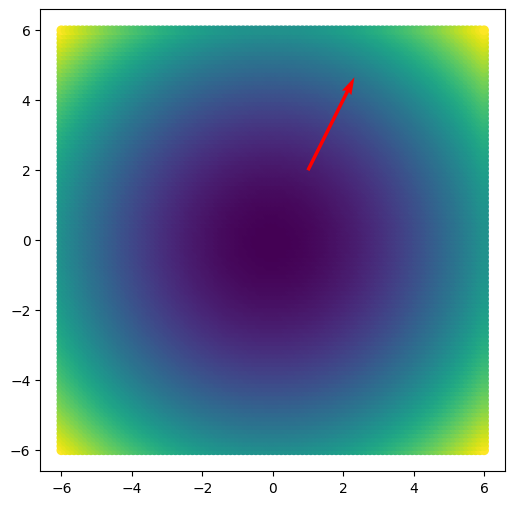

In [3]:
# plot
import matplotlib.pyplot as plt
xs1, xs2 = jnp.meshgrid(
    jnp.linspace(-6, 6, 101), 
    jnp.linspace(-6, 6, 101))
xs1 = xs1.reshape(101**2, 1)
xs2 = xs2.reshape(101**2, 1)
xs = jnp.concatenate((xs1, xs2), axis=-1)
fs = jax.vmap(f)(xs)
plt.figure(figsize=[6, 6])
plt.scatter(xs1, xs2, c=fs)
plt.quiver(x[1], x[2], dfxT_1[0][1], dfxT_1[0][2],
    scale=10, color='r')
plt.show()

## Example: JVP as a directional derivative
The directional derivative of $f : \mathbb{R}^n \to \mathbb{R}$ at $x \in \mathbb{R}^n$ along $v \in \mathbb{R}^n$ is

$$
\nabla{f}(x)^\top v  = \partial{f}(x)v.
$$

E.g., if $f(x) = \frac{1}{2}\|x\|_2^2$, then $\nabla{f}(x)^\top v = x^\top v$.

In [4]:
f = lambda x: jnp.sum(x**2)/2
x = jnp.array([0., 1., 2.])
v = jnp.array([1., 1., 1.])

# use tuples to separate inputs from seeds
f_x, dfx_v = jax.jvp(f, (x,), (v,))

print('x:     ', x)
print('f(x):  ', f_x)
print('dfx(v):', dfx_v)

x:      [0. 1. 2.]
f(x):   2.5
dfx(v): 3.0


## Example: Multi-input, multi-output VJP
Let's try something more complicated:

$$
\begin{aligned}
f : \mathbb{R}^n \times \mathbb{R}^n &\to \mathbb{R} \times \mathbb{R} \\
(x,y) &\mapsto \left(\frac{1}{2}\|x\|_2^2 + \frac{1}{2}\|y\|_2^2, \sum_{i=1}^n x_i \right)
\end{aligned}
$$

In [5]:
def f(x, y):
    f1 = jnp.sum(x**2)/2 + jnp.sum(y**2)/2
    f2 = jnp.sum(x)
    return f1, f2

x = jnp.array([0., 1., 2.])
y = jnp.array([0., 1., 2.])
f_xy, dfT = jax.vjp(f, x, y)

print('x,y:     ', x, y)
print('f(x,y):  ', f_xy)
print('dfT(1,1):', dfT((1., 1.)))  # provide tuple as input

x,y:      [0. 1. 2.] [0. 1. 2.]
f(x,y):   (DeviceArray(5., dtype=float32), DeviceArray(3., dtype=float32))
dfT(1,1): (DeviceArray([1., 2., 3.], dtype=float32), DeviceArray([0., 1., 2.], dtype=float32))


## Example: VJP and JVP for a Matrix Input
We can generalize VJPs and JVPs to non-vector inputs as well:

$$
\begin{aligned}
f : \mathbb{R}^{n \times n} &\to \mathbb{R} \\
X &\mapsto a^\top X b
\end{aligned}
$$

In [6]:
def f(X):
    a, b = jnp.array([0., 1., 2.]), jnp.array([0., 1., 2.])
    return a @ (X @ b)

X = jnp.ones((3, 3))
f_x = f(X)
w, V = jnp.array(1.), jnp.eye(3)
f_x, dfT = jax.vjp(f, X)
f_x, df_v = jax.jvp(f, (X,), (V,))

print('X:\n', X, '\n', 'f(X): ', f_x, '\n', sep='')
print('dfT(1):\n', dfT(w), '\n', 'df(I): ', df_v, sep='')

X:
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
f(X): 9.0

dfT(1):
(DeviceArray([[0., 0., 0.],
             [0., 1., 2.],
             [0., 2., 4.]], dtype=float32),)
df(I): 5.0


# Auto-Vectorizing Functions with `jax.vmap`

For some complicated function $f : \mathbb{R}^n \to \mathbb{R}^m$, we want to calculate $f(x)$ for *many* different values of $x$ without looping. 

This is known as *vectorizing* a function. JAX can do this automatically!

In [7]:
f = lambda x: jnp.array([jnp.sum(x**2)/2, jnp.linalg.norm(x, jnp.inf)])
f = jax.vmap(f)

batch_size, n = 100, 3
x = jnp.ones((batch_size, n))  # dummy values with desired shape

print(x.shape)
print(f(x).shape)

(100, 3)
(100, 2)


## Example: Batch Evaluation of a Neural Network

In [8]:
def f(x, W, b): 
    return W[1] @ jnp.tanh(W[0] @ x + b[0]) + b[1]
f = jax.vmap(f, in_axes=(0, None, None))
f = jax.vmap(f, in_axes=(0, None, None))

n, m = 3, 5
batch_size = 100
hdim = 32

W = (jnp.ones((hdim, n)), jnp.ones((m, hdim)))
b = (jnp.ones(hdim), jnp.ones(m))
x = jnp.ones((40, batch_size, n))

print(x.shape)
print(f(x, W, b).shape)

(40, 100, 3)
(40, 100, 5)


## Example: Jacobian Matrix from JVPs and VJPs

Let $e^{(d)}_k \in \{0,1\}^d$ denote the $k^\text{th}$ coordinate vector in $d$ dimensions. 

For $f : \mathbb{R}^n \to \mathbb{R}^m$, we can compute the full Jacobian $\partial{f}(x) \in \mathbb{R}^{m \times n}$ with either $n$ JVPs

$$
\partial{f}(x) = \partial{f}(x)I_n = \begin{bmatrix}
    \partial{f}(x)e^{(n)}_1 & \partial{f}(x)e^{(n)}_2 & \cdots & \partial{f}(x)e^{(n)}_n
\end{bmatrix},
$$

or $m$ VJPs
$$
\partial{f}(x)^\top = \partial{f}(x)^\top I_m = \begin{bmatrix}
    \partial{f}(x)^\top e^{(m)}_1 & \partial{f}(x)^\top e^{(m)}_2 & \cdots & \partial{f}(x)^\top e^{(m)}_m
\end{bmatrix}.
$$

This is what the source code for `jax.jacfwd` and `jac.jacrev` does.

In [9]:
f = lambda x: jnp.array([x[0], x[0]**2 + x[2]**2])

def df(x, v):
    fx, dfx_v = jax.jvp(f, (x,), (v,))
    return dfx_v

def dfT(x, w):
    fx, dfxT = jax.vjp(f, x)
    return dfxT(w)[0]  # need to index into tuple

n, m = 3, 2
x = jnp.ones(n)
Jx = jax.vmap(df, in_axes=(None, 0))(x, jnp.eye(n))
JxT = jax.vmap(dfT, in_axes=(None, 0))(x, jnp.eye(m))
print('Jacobian (forward AD):')
print(Jx)
print('\nJacobian (reverse AD):')
print(JxT)

Jacobian (forward AD):
[[1. 2.]
 [0. 0.]
 [0. 2.]]

Jacobian (reverse AD):
[[1. 0. 0.]
 [2. 0. 2.]]


## Example: Linearizing Dynamics at Many Points
For $\dot{x} = f(x,u)$ with $x \in \mathbb{R}^n$ and $u \in \mathbb{R}^m$, recall the first-order Taylor approximation

$$
f(x,u) \approx \underbrace{f(\bar{x}_k,\bar{u}_k)}_{= c_k}
    + \underbrace{\partial_x{f}(\bar{x}_k,\bar{u}_k)}_{= A_k}(x - \bar{x})
    + \underbrace{\partial_u{f}(\bar{x}_k,\bar{u}_k)}_{= B_k}(u - \bar{u}).
$$

We want $A_k\Delta{x}_t$, $B_k\Delta{u}_t$, and $c_k$ for $\{(\bar{x}_k,\bar{u}_k)\}_{k=1}^K$ and $\{(\Delta{x}_t,\Delta{u}_t)\}_{t=1}^T$.

This scenario may correspond to evaluating Taylor approximations for $T$ perturbations $(\Delta{x}_t,\Delta{u}_t)$ that we want to test at the $K$ points $(\bar{x}_k,\bar{u}_k)$.

In [10]:
# Inverted pendulum (with unit mass and unit length)
f = lambda x, u: jnp.array([x[1], 9.81*jnp.sin(x[0]) + u[0]])

def taylor(x̄, ū, Δx, Δu):
    f_x̄ū, AΔx = jax.jvp(lambda x: f(x, ū), (x̄,), (Δx,))
    _, BΔu = jax.jvp(lambda u: f(x̄, u), (ū,), (Δu,))
    return f_x̄ū, AΔx, BΔu

print(type(taylor))

n, m = 2, 1
K, T = 5, 10
x̄, ū = jnp.ones((K, n)), jnp.ones((K, m))
Δx, Δu = jnp.ones((T, n)), jnp.ones((T, m))

taylor = jax.vmap(taylor, in_axes=(None, None, 0, 0))
print(type(taylor))

taylor = jax.vmap(taylor, in_axes=(0, 0, None, None))
print(type(taylor))

c, Ax, Bu = taylor(x̄, ū, Δx, Δu)
print(c.shape)
print(Ax.shape)
print(Bu.shape)

<class 'function'>
<class 'function'>
<class 'function'>
(5, 10, 2)
(5, 10, 2)
(5, 10, 2)


If, instead, we have $K=5$ trajectories $\{(\bar{x}_k,\bar{u}_k)\}_{k=1}^K$ and each trajectory $\bar{x}_k$ has $T=10$ timesteps $\{(\bar{x}_{k,t},\bar{u}_{k,t})\}_{t=1}^T$, and similarly for $(\Delta{x},\Delta{u})$, then we can evaluate Taylor approximations for all these trajectories with two calls to vmap as below.

In [11]:
# Inverted pendulum (with unit mass and unit length)
f = lambda x, u: jnp.array([x[1], 9.81*jnp.sin(x[0]) + u[0]])
def taylor(x̄, ū, Δx, Δu):
    f_x̄ū, AΔx = jax.jvp(lambda x: f(x, ū), (x̄,), (Δx,))
    f_x̄ū, BΔu = jax.jvp(lambda u: f(x̄, u), (ū,), (Δu,))
    return f_x̄ū, AΔx, BΔu

n, m = 2, 1
K, T = 5, 10
x̄ = jnp.ones((K, T, n)) # note the different sizes
ū = jnp.ones((K, T, m))
Δx, Δu = jnp.ones((K, T, n)), jnp.ones((K, T, m))

# two successive calls to vmap:
# we linearize for the K trajectories that each have T timesteps
taylor = jax.vmap(taylor)
taylor = jax.vmap(taylor)

c, Ax, Bu = taylor(x̄, ū, Δx, Δu)
print(c.shape)
print(Ax.shape)
print(Bu.shape)

(5, 10, 2)
(5, 10, 2)
(5, 10, 2)


# Other Features and Nuances of JAX

See the [JAX documentation](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html) for more details.

## Just-In-Time (JIT) Compilation

JAX can compile code to run fast on both CPUs and GPUs. The first call to a "jitted" function will compile and cache the function; subsequent calls are then much faster.

In [12]:
def selu(x, alpha=1.67, lmbda=1.05):
    return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

x = jnp.ones(int(1e7))
%timeit -r10 -n100 selu(x).block_until_ready()

selu_jit = jax.jit(selu)
%timeit -r10 -n100 selu_jit(x).block_until_ready()

42.5 ms ± 2.95 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)
10.4 ms ± 426 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


## In-Place Updates

JAX arrays are immutable. In keeping with the functional programming paradigm, updates to array values at indices are done via JAX functions.

In [13]:
X = jnp.zeros((3,3))
try:
    X[0, :] = 1.
except Exception as e:
    print("Exception: {}".format(e))
print('\nX:\n', X, sep='')

Y = X.at[0, :].set(1.)
print('\nY:\n', Y, sep='')

Exception: '<class 'jaxlib.xla_extension.DeviceArray'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

X:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

Y:
[[1. 1. 1.]
 [0. 0. 0.]
 [0. 0. 0.]]


## Pseudo-Random Number Generation (PRNG)

JAX does explicit PRNG; after initiailizing a PRNG state, it can be forked into new PRNG states for parallel stochastic generation. 

This enables reproducible results; propagate the key and make new subkeys whenever new random numbers are needed.

In [14]:
seed = 0
key = jax.random.PRNGKey(seed)
print(jax.random.normal(key, shape=(1,)))
print(jax.random.normal(key, shape=(1,)))  # same value sampled!

print('\nkey', key)
key, *subkeys = jax.random.split(key, 3)
print('|-- SPLIT --> key    ', key)
print('          --> subkeys', subkeys[0], 
      '--> normal', jax.random.normal(subkeys[0], shape=(1,)))
print('                     ', subkeys[1], 
      '--> normal', jax.random.normal(subkeys[1], shape=(1,)))

[-0.20584226]
[-0.20584226]

key [0 0]
|-- SPLIT --> key     [2467461003  428148500]
          --> subkeys [3186719485 3840466878] --> normal [0.5781488]
                      [2562233961 1946702221] --> normal [0.8535516]
